# ECON 5140: Applied Econometrics
## Lesson 2: Time Series Foundations & Decomposition

This notebook demonstrates time series fundamentals using real economic data.

**Topics covered:**
1. Time series structure and indexing
2. Visualization (time plots, ACF)
3. Time series decomposition (additive vs multiplicative)
4. STL decomposition


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Time series specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For downloading real economic data
try:
    import yfinance as yf  # For stock market data (install with: pip install yfinance)
    YFINANCE_AVAILABLE = True
except ImportError:
    YFINANCE_AVAILABLE = False
    print("Note: yfinance not available. Will use synthetic data as fallback.")
    print("To install yfinance: pip install yfinance")

try:
    import pandas_datareader.data as web  # For FRED data
    FRED_AVAILABLE = True
except ImportError:
    FRED_AVAILABLE = False
    print("Note: pandas_datareader not available. Will use synthetic data as fallback.")
    print("To install: pip install pandas-datareader")

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================================
# HELPER FUNCTIONS FOR EASIER PLOTTING
# ============================================================================
# These functions make it easier for beginners to create plots

def simple_time_plot(series, title, ylabel=None, figsize=(12, 5)):
    """
    Simple function to plot a time series.
    
    Parameters:
    - series: pandas Series with datetime index
    - title: plot title (string)
    - ylabel: y-axis label (string, optional)
    - figsize: figure size tuple (default: (12, 5))
    
    Returns:
    - fig, ax: matplotlib figure and axis objects
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(series.index, series.values, linewidth=2)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel if ylabel else 'Value')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax

def plot_with_break(series, break_date, title, ylabel=None, figsize=(12, 5)):
    """
    Plot time series with a vertical line marking a structural break.
    
    Parameters:
    - series: pandas Series with datetime index
    - break_date: date string or datetime object marking the break
    - title: plot title
    - ylabel: y-axis label (optional)
    - figsize: figure size tuple
    
    Returns:
    - fig, ax: matplotlib figure and axis objects
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(series.index, series.values, linewidth=2)
    ax.axvline(x=pd.to_datetime(break_date), color='red', linestyle='--', 
              linewidth=2, label=f'Break: {break_date}')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel if ylabel else 'Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax

print("Helper functions loaded! Now plotting is easier:")
print("  - simple_time_plot(series, title) - quick time series plot")
print("  - plot_with_break(series, break_date, title) - plot with structural break marked")


Helper functions loaded! Now plotting is easier:
  - simple_time_plot(series, title) - quick time series plot
  - plot_with_break(series, break_date, title) - plot with structural break marked


## Part 1: Time Series Structure and Indexing

**Key concepts:**
- Time index: defines when observations occur
- Frequency: daily, weekly, monthly, quarterly, etc.
- Regularity: evenly spaced vs irregular
- The index controls lag operations, rolling windows, and resampling


### Example 1: Daily Stock Price Data


In [3]:
# Example 1: Download daily stock price data (AAPL - Apple Inc.)
# Daily data from 2020 to 2024
print("Downloading daily stock price data...")

if YFINANCE_AVAILABLE:
    try:
        ticker = yf.Ticker("AAPL")
        stock_data = ticker.history(start="2020-01-01", end="2024-12-31")
        daily_prices = stock_data['Close'].copy()
        print("Successfully downloaded AAPL stock data from Yahoo Finance")
    except Exception as e:
        print(f"Error downloading from yfinance: {e}")
        print("Creating synthetic stock price data...")
        YFINANCE_AVAILABLE = False

if not YFINANCE_AVAILABLE:
    # Create realistic synthetic daily stock price data
    print("Creating synthetic daily stock price data...")
    dates = pd.date_range(start='2020-01-01', end='2024-12-31', freq='B')  # Business days
    # Generate realistic stock price with trend, volatility, and some correlation
    n = len(dates)
    returns = np.random.normal(0.0005, 0.02, n)  # Daily returns ~0.05% mean, 2% std
    # Add some autocorrelation and trend
    trend = np.linspace(100, 180, n)
    cumulative_returns = np.cumsum(returns)
    daily_prices = pd.Series(trend * (1 + cumulative_returns * 0.1), index=dates)
    daily_prices = daily_prices.clip(lower=50)  # Ensure positive prices
    print("Created synthetic stock price data")

print(f"\nDaily Stock Price Data:")
print(f"Frequency: Daily")
print(f"Date range: {daily_prices.index.min()} to {daily_prices.index.max()}")
print(f"Number of observations: {len(daily_prices)}")
print(f"\nFirst few observations:")
print(daily_prices.head(10))
print(f"\nData type of index: {type(daily_prices.index)}")
print(f"Index is DatetimeIndex: {isinstance(daily_prices.index, pd.DatetimeIndex)}")


Successfully downloaded AAPL stock data from Yahoo Finance

Daily Stock Price Data:
Frequency: Daily
Date range: 2020-01-02 00:00:00-05:00 to 2024-12-30 00:00:00-05:00
Number of observations: 1257

First few observations:
Date
2020-01-02 00:00:00-05:00    72.468254
2020-01-03 00:00:00-05:00    71.763725
2020-01-06 00:00:00-05:00    72.335556
2020-01-07 00:00:00-05:00    71.995384
2020-01-08 00:00:00-05:00    73.153488
2020-01-09 00:00:00-05:00    74.707344
2020-01-10 00:00:00-05:00    74.876228
2020-01-13 00:00:00-05:00    76.475906
2020-01-14 00:00:00-05:00    75.443237
2020-01-15 00:00:00-05:00    75.119919
Name: Close, dtype: float64

Data type of index: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index is DatetimeIndex: True


### Example 2: Monthly Economic Data - US Exports


In [4]:
# Example 2: Monthly economic data - US Exports
# Using FRED (Federal Reserve Economic Data) via pandas_datareader
print("Downloading monthly US exports data from FRED...")

if FRED_AVAILABLE:
    try:
        # US Exports of Goods and Services (monthly, seasonally adjusted)
        # FRED series code: EXPGS
        exports = web.DataReader('EXPGS', 'fred', start='2010-01-01', end='2024-12-31')
        exports_monthly = exports['EXPGS'].dropna()
        print("Successfully downloaded US exports data from FRED")
    except Exception as e:
        print(f"Error downloading FRED data: {e}")
        print("Using synthetic monthly export data for demonstration...")
        FRED_AVAILABLE = False

if not FRED_AVAILABLE:
    # Create synthetic monthly export data if FRED is unavailable
    print("Creating synthetic monthly export data...")
    dates = pd.date_range(start='2010-01-01', end='2024-12-31', freq='M')
    trend = np.linspace(200, 350, len(dates))
    seasonal = 20 * np.sin(2 * np.pi * np.arange(len(dates)) / 12)
    noise = np.random.normal(0, 5, len(dates))
    exports_monthly = pd.Series(trend + seasonal + noise, index=dates)
    exports_monthly = exports_monthly.clip(lower=150)
    print(f"Created synthetic monthly export data with {len(exports_monthly)} observations")

print(f"\nMonthly US Exports Data:")
print(f"Frequency: Monthly")
print(f"Date range: {exports_monthly.index.min()} to {exports_monthly.index.max()}")
print(f"Number of observations: {len(exports_monthly)}")
print(f"\nFirst few observations:")
print(exports_monthly.head(10))
print(f"\nUnits: Billions of Dollars (seasonally adjusted)")


Successfully downloaded US exports data from FRED

Monthly US Exports Data:
Frequency: Monthly
Date range: 2010-01-01 00:00:00 to 2024-10-01 00:00:00
Number of observations: 60

First few observations:
DATE
2010-01-01    1759.877
2010-04-01    1819.741
2010-07-01    1877.253
2010-10-01    1972.116
2011-01-01    2040.407
2011-04-01    2116.132
2011-07-01    2156.793
2011-10-01    2150.123
2012-01-01    2189.981
2012-04-01    2215.586
Name: EXPGS, dtype: float64

Units: Billions of Dollars (seasonally adjusted)


## Part 2: Visualization - The Foundation of Time Series Analysis

**Key visualizations:**
- Time plot: shows trends, level shifts, outliers
- ACF plot: shows temporal dependence and autocorrelation

Visualization is essential before modeling - it reveals patterns that guide model selection.


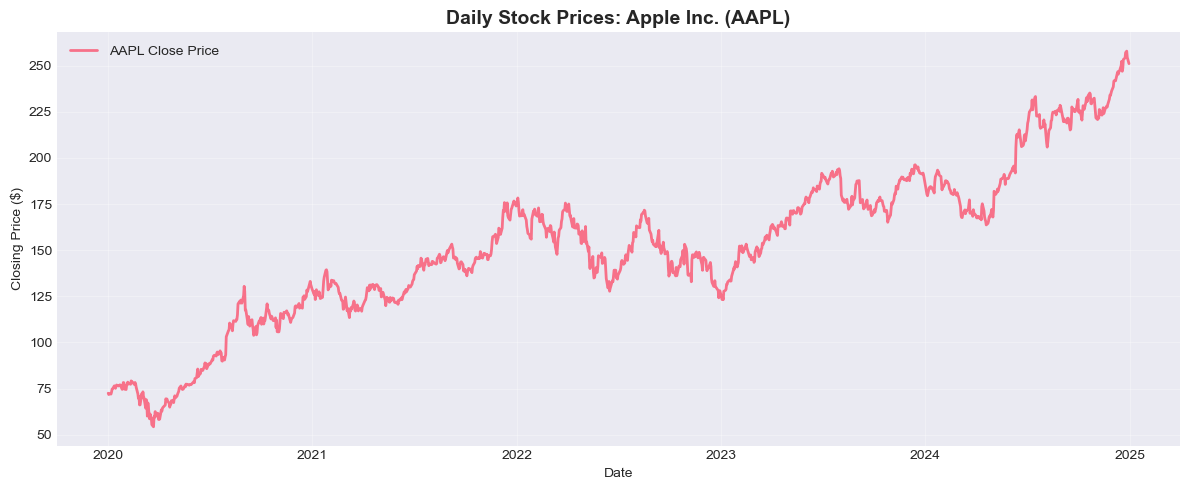

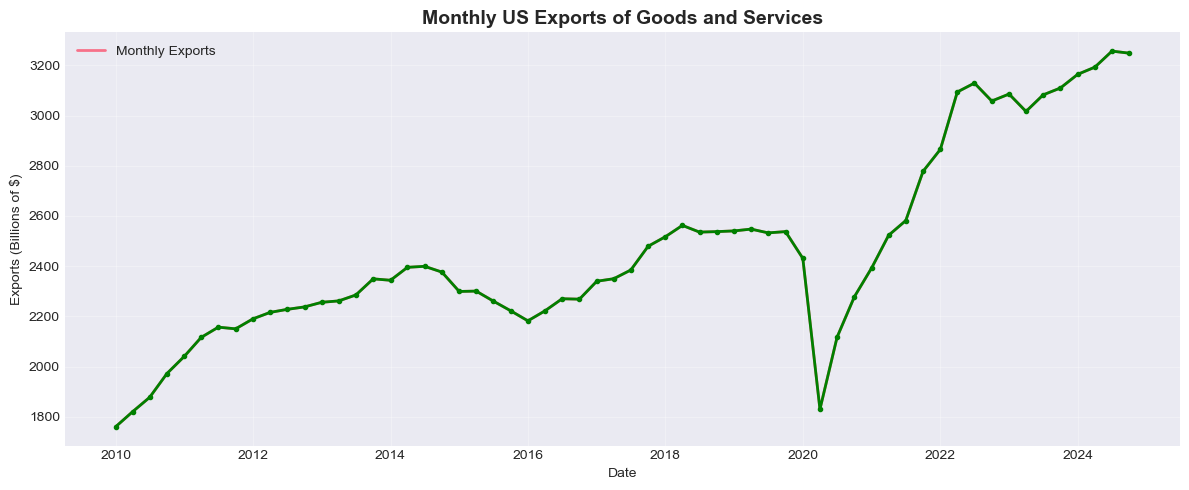

Key observations from time plots:
1. Daily stock prices: Volatile, trending upward, potential structural breaks
2. Monthly exports: Clear seasonal patterns, overall growth trend

Tip: Use simple_time_plot() function for quick time series plots!


In [5]:
# Easy time plots using our helper function
# Option 1: Use the helper function (simpler!)
fig1, ax1 = simple_time_plot(daily_prices, 
                             'Daily Stock Prices: Apple Inc. (AAPL)', 
                             ylabel='Closing Price ($)')
ax1.legend(['AAPL Close Price'], loc='upper left')
plt.show()

fig2, ax2 = simple_time_plot(exports_monthly, 
                             'Monthly US Exports of Goods and Services', 
                             ylabel='Exports (Billions of $)')
ax2.plot(exports_monthly.index, exports_monthly.values, 
        linewidth=2, color='green', marker='o', markersize=3)
ax2.legend(['Monthly Exports'], loc='upper left')
plt.show()

print("Key observations from time plots:")
print("1. Daily stock prices: Volatile, trending upward, potential structural breaks")
print("2. Monthly exports: Clear seasonal patterns, overall growth trend")
print("\nTip: Use simple_time_plot() function for quick time series plots!")


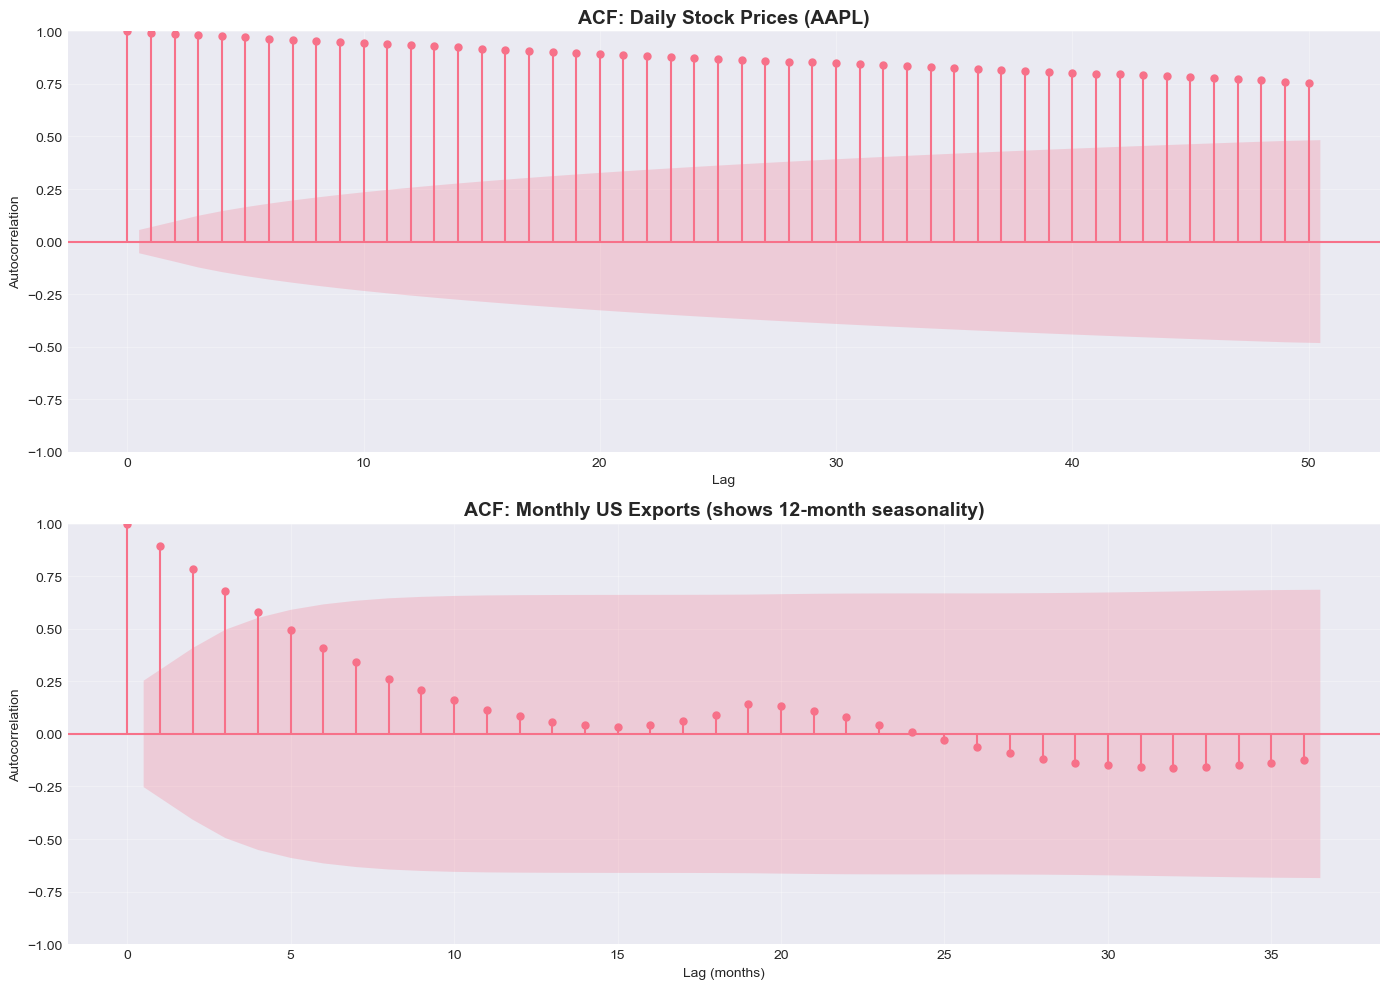

Interpreting ACF plots:
1. Daily stock prices: Slow decay suggests strong persistence/trend
2. Monthly exports: Spikes at lags 12, 24, 36 indicate yearly seasonality


In [6]:
# Autocorrelation Function (ACF) plots
# ACF shows how observations are correlated with past observations

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ACF for daily stock prices (first 50 lags)
plot_acf(daily_prices.dropna(), lags=50, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF: Daily Stock Prices (AAPL)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')
axes[0].grid(True, alpha=0.3)

# ACF for monthly exports (first 36 lags to show yearly seasonality)
plot_acf(exports_monthly.dropna(), lags=36, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF: Monthly US Exports (shows 12-month seasonality)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag (months)')
axes[1].set_ylabel('Autocorrelation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpreting ACF plots:")
print("1. Daily stock prices: Slow decay suggests strong persistence/trend")
print("2. Monthly exports: Spikes at lags 12, 24, 36 indicate yearly seasonality")


## Part 3: COVID-19 Impact on Economic Data - Structural Breaks

**Structural break**: A sudden change in the level or trend of a time series.

**COVID-19 created structural breaks in many economic series:**
- **Level change**: Sudden drop in employment, retail sales, GDP
- **Trend change**: Changing growth rates before/after pandemic
- **Date of break**: March 2020 (COVID lockdowns began)

**Real-world example**: We'll examine US unemployment rate and retail sales to see:
1. Visual evidence of structural break
2. How to identify the break date
3. How to visualize before/after trends


In [8]:
# COVID-19 Economic Impact: US Unemployment Rate
# Download from FRED (Federal Reserve Economic Data)
print("Downloading US Unemployment Rate data from FRED...")

if FRED_AVAILABLE:
    try:
        # US Unemployment Rate (monthly, seasonally adjusted)
        # FRED series code: UNRATE
        unemployment = web.DataReader('UNRATE', 'fred', start='2015-01-01', end='2024-12-31')
        unemployment_rate = unemployment['UNRATE'].dropna()
        print("✓ Successfully downloaded US unemployment rate data from FRED")
        print(f"  Date range: {unemployment_rate.index.min()} to {unemployment_rate.index.max()}")
        print(f"  Units: Percent (seasonally adjusted)")
    except Exception as e:
        print(f"Error downloading FRED data: {e}")
        print("Creating synthetic unemployment data with COVID impact...")
        FRED_AVAILABLE = False

if not FRED_AVAILABLE:
    # Create realistic synthetic unemployment data with COVID impact
    print("Creating synthetic unemployment rate data with COVID structural break...")
    dates = pd.date_range(start='2015-01-01', end='2024-12-31', freq='M')
    n = len(dates)
    
    # Pre-COVID: Low unemployment (4-5%)
    pre_covid_idx = dates < '2020-03-01'
    n_pre = pre_covid_idx.sum()
    pre_covid_ur = 4.5 + np.random.normal(0, 0.3, n_pre)
    
    # COVID shock: Sudden jump (March-April 2020)
    covid_start_idx = (dates >= '2020-03-01') & (dates < '2020-05-01')
    n_covid = covid_start_idx.sum()
    covid_ur = 14.0 + np.random.normal(0, 1, n_covid)  # Peak ~14%
    
    # Recovery period: Gradual decline
    recovery_idx = (dates >= '2020-05-01') & (dates < '2022-01-01')
    n_recovery = recovery_idx.sum()
    recovery_trend = np.linspace(14, 6, n_recovery)
    recovery_ur = recovery_trend + np.random.normal(0, 0.5, n_recovery)
    
    # Post-COVID: Lower unemployment
    post_covid_idx = dates >= '2022-01-01'
    n_post = post_covid_idx.sum()
    post_covid_ur = 3.5 + np.random.normal(0, 0.2, n_post)
    
    # Combine
    unemployment_rate = pd.Series(
        np.concatenate([pre_covid_ur, covid_ur, recovery_ur, post_covid_ur]),
        index=dates
    )
    unemployment_rate = unemployment_rate.clip(lower=2.0)  # Ensure reasonable bounds
    print(f"✓ Created synthetic unemployment rate data with {len(unemployment_rate)} observations")

print(f"\nUnemployment Rate Data Summary:")
print(unemployment_rate.describe())
print(f"\nFirst 5 observations:")
print(unemployment_rate.head())


✓ Successfully downloaded US unemployment rate data from FRED
  Date range: 2015-01-01 00:00:00 to 2024-12-01 00:00:00
  Units: Percent (seasonally adjusted)

Unemployment Rate Data Summary:
count    120.000000
mean       4.682500
std        1.733198
min        3.400000
25%        3.700000
50%        4.100000
75%        5.000000
max       14.800000
Name: UNRATE, dtype: float64

First 5 observations:
DATE
2015-01-01    5.7
2015-02-01    5.5
2015-03-01    5.4
2015-04-01    5.4
2015-05-01    5.6
Name: UNRATE, dtype: float64


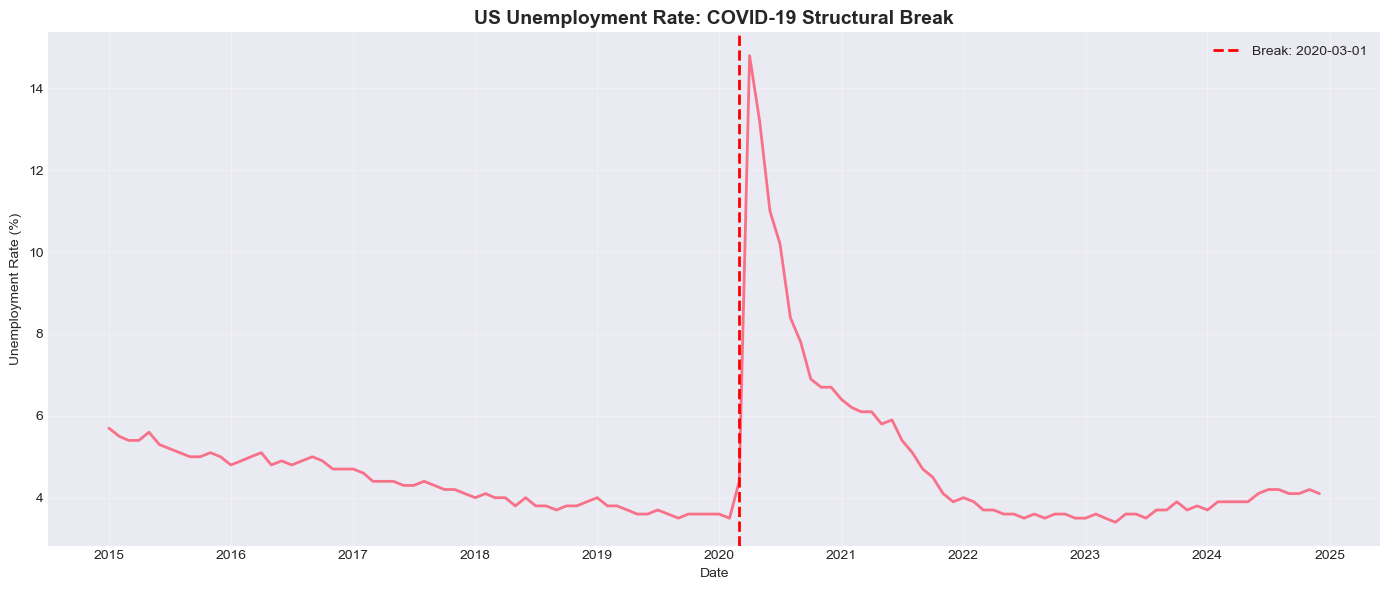

STRUCTURAL BREAK ANALYSIS: COVID-19 Impact

Before COVID (up to 2020-03-01):
  Mean unemployment rate: 4.39%
  Std deviation: 0.63%
  Range: 3.50% to 5.70%

After COVID (from 2020-03-01):
  Mean unemployment rate: 5.00%
  Std deviation: 2.38%
  Range: 3.40% to 14.80%

Level Change:
  Change in mean: 0.61 percentage points
  Percent change: 13.9%


In [9]:
# Visualize unemployment rate with COVID structural break
covid_break_date = '2020-03-01'  # Approximate start of COVID lockdowns

# Use our helper function
plot_with_break(unemployment_rate, covid_break_date, 
                'US Unemployment Rate: COVID-19 Structural Break', 
                ylabel='Unemployment Rate (%)', figsize=(14, 6))
plt.show()

# Calculate statistics before and after COVID
pre_covid = unemployment_rate[unemployment_rate.index < covid_break_date]
post_covid = unemployment_rate[unemployment_rate.index >= covid_break_date]

print("="*80)
print("STRUCTURAL BREAK ANALYSIS: COVID-19 Impact")
print("="*80)
print(f"\nBefore COVID (up to {covid_break_date}):")
print(f"  Mean unemployment rate: {pre_covid.mean():.2f}%")
print(f"  Std deviation: {pre_covid.std():.2f}%")
print(f"  Range: {pre_covid.min():.2f}% to {pre_covid.max():.2f}%")

print(f"\nAfter COVID (from {covid_break_date}):")
print(f"  Mean unemployment rate: {post_covid.mean():.2f}%")
print(f"  Std deviation: {post_covid.std():.2f}%")
print(f"  Range: {post_covid.min():.2f}% to {post_covid.max():.2f}%")

print(f"\nLevel Change:")
print(f"  Change in mean: {post_covid.mean() - pre_covid.mean():.2f} percentage points")
print(f"  Percent change: {(post_covid.mean() / pre_covid.mean() - 1) * 100:.1f}%")


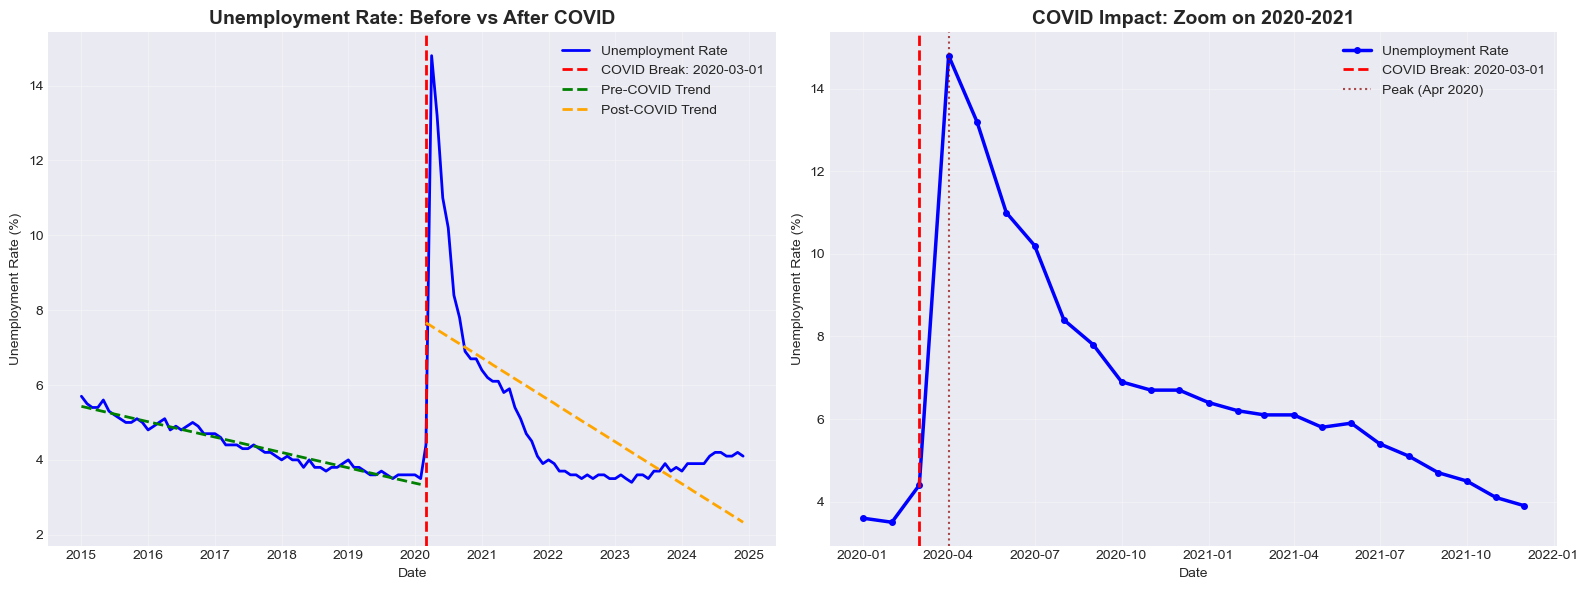

Pre-COVID trend: -0.0342 per month (slight upward)
Post-COVID trend: -0.0935 per month (downward recovery)

Key observations:
1. Sudden level increase in March 2020 (structural break)
2. Peak unemployment in April 2020 (~14.8%)
3. Gradual recovery after peak (trend reversal)
4. Eventually returns to pre-COVID levels (late 2021-2022)


In [10]:
# Visualize trend before and after COVID
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Full series with trend lines
axes[0].plot(unemployment_rate.index, unemployment_rate.values, 
            linewidth=2, label='Unemployment Rate', color='blue')
axes[0].axvline(x=pd.to_datetime(covid_break_date), color='red', linestyle='--', 
               linewidth=2, label=f'COVID Break: {covid_break_date}')

# Fit trend lines before and after
from scipy import stats
pre_dates_numeric = np.arange(len(pre_covid))
post_dates_numeric = np.arange(len(pre_covid), len(unemployment_rate))

pre_trend = stats.linregress(pre_dates_numeric, pre_covid.values)
post_trend = stats.linregress(post_dates_numeric, post_covid.values)

axes[0].plot(pre_covid.index, pre_trend.slope * pre_dates_numeric + pre_trend.intercept,
            '--', color='green', linewidth=2, label='Pre-COVID Trend')
axes[0].plot(post_covid.index, post_trend.slope * post_dates_numeric + post_trend.intercept,
            '--', color='orange', linewidth=2, label='Post-COVID Trend')

axes[0].set_title('Unemployment Rate: Before vs After COVID', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Unemployment Rate (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Zoom in on COVID period (2020-2021)
covid_period = unemployment_rate['2020-01-01':'2021-12-31']
axes[1].plot(covid_period.index, covid_period.values, 
            linewidth=2.5, marker='o', markersize=4, label='Unemployment Rate', color='blue')
axes[1].axvline(x=pd.to_datetime(covid_break_date), color='red', linestyle='--', 
               linewidth=2, label=f'COVID Break: {covid_break_date}')
axes[1].axvline(x=pd.to_datetime('2020-04-01'), color='darkred', linestyle=':', 
               linewidth=1.5, alpha=0.7, label='Peak (Apr 2020)')
axes[1].set_title('COVID Impact: Zoom on 2020-2021', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Unemployment Rate (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Pre-COVID trend: {pre_trend.slope:.4f} per month (slight upward)")
print(f"Post-COVID trend: {post_trend.slope:.4f} per month (downward recovery)")
print(f"\nKey observations:")
print(f"1. Sudden level increase in March 2020 (structural break)")
print(f"2. Peak unemployment in April 2020 (~{covid_period.max():.1f}%)")
print(f"3. Gradual recovery after peak (trend reversal)")
print(f"4. Eventually returns to pre-COVID levels (late 2021-2022)")



EXAMPLE 2: Retail Sales - COVID Impact
✓ Successfully downloaded US retail sales data from FRED


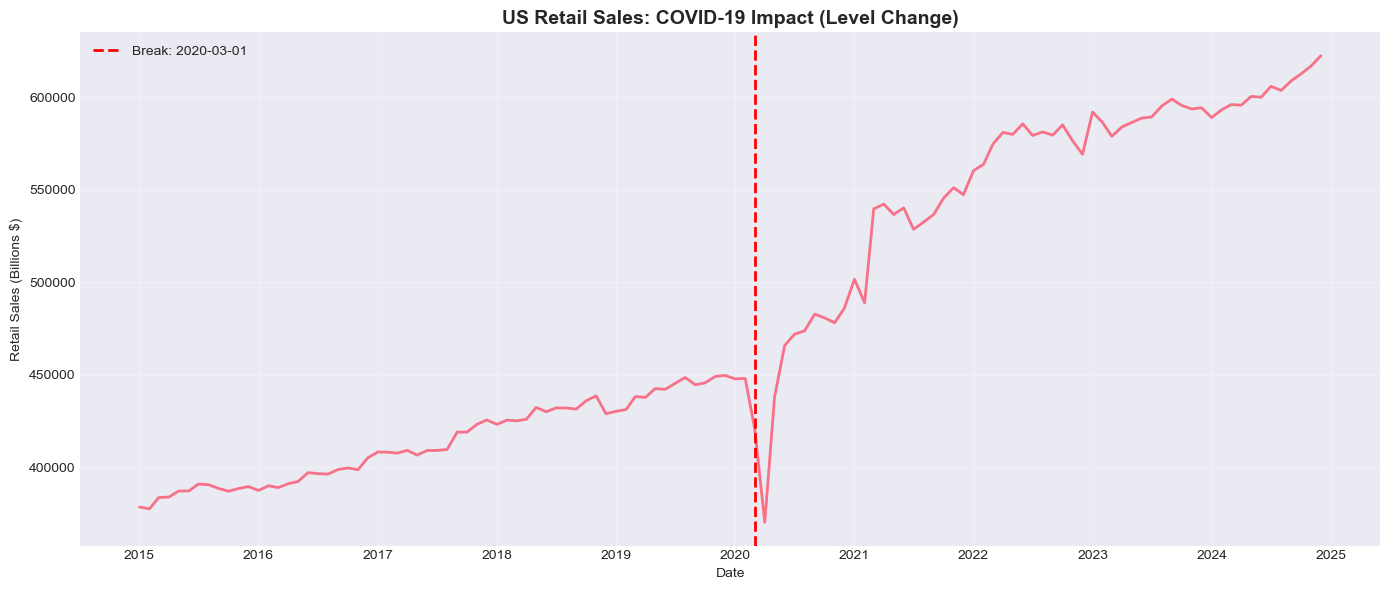


Before COVID: Mean = $414374.0B, Std = $22236.6B
After COVID: Mean = $555178.6B, Std = $54531.8B
Level change: $140804.6B (34.0%)

COVID Impact Summary:
1. Sharp drop in March-April 2020 (lockdowns)
2. V-shape recovery starting May 2020
3. Eventually recovered to pre-COVID levels and beyond
4. Shows both level change (drop) and trend change (recovery)


In [11]:
# Example 2: Retail Sales (also heavily affected by COVID)
print("\n" + "="*80)
print("EXAMPLE 2: Retail Sales - COVID Impact")
print("="*80)

if FRED_AVAILABLE:
    try:
        # US Retail Sales (monthly, seasonally adjusted, in billions)
        # FRED series code: RSXFS
        retail_sales = web.DataReader('RSXFS', 'fred', start='2015-01-01', end='2024-12-31')
        retail_sales_data = retail_sales['RSXFS'].dropna()
        print("✓ Successfully downloaded US retail sales data from FRED")
        covid_break_retail = '2020-03-01'
    except Exception as e:
        print(f"Error: {e}")
        print("Creating synthetic retail sales data with COVID impact...")
        FRED_AVAILABLE = False

if not FRED_AVAILABLE:
    # Create synthetic retail sales with COVID impact
    dates_retail = pd.date_range(start='2015-01-01', end='2024-12-31', freq='M')
    n_retail = len(dates_retail)
    
    # Pre-COVID: Steady growth
    pre_covid_retail_idx = dates_retail < '2020-03-01'
    n_pre_retail = pre_covid_retail_idx.sum()
    trend_pre = np.linspace(400, 520, n_pre_retail)
    seasonal_pre = 20 * np.sin(2 * np.pi * np.arange(n_pre_retail) / 12)
    pre_retail = trend_pre + seasonal_pre + np.random.normal(0, 5, n_pre_retail)
    
    # COVID shock: Sharp drop (March-May 2020)
    covid_drop_idx = (dates_retail >= '2020-03-01') & (dates_retail < '2020-06-01')
    n_drop = covid_drop_idx.sum()
    drop_levels = np.linspace(520, 380, n_drop)  # Sharp drop
    covid_retail_drop = drop_levels + np.random.normal(0, 10, n_drop)
    
    # Recovery: V-shape recovery
    recovery_retail_idx = (dates_retail >= '2020-06-01') & (dates_retail < '2021-12-01')
    n_recovery_retail = recovery_retail_idx.sum()
    recovery_trend_retail = np.linspace(380, 580, n_recovery_retail)  # Strong recovery
    seasonal_recovery = 20 * np.sin(2 * np.pi * np.arange(n_recovery_retail) / 12)
    recovery_retail = recovery_trend_retail + seasonal_recovery + np.random.normal(0, 8, n_recovery_retail)
    
    # Post-COVID: Higher level with growth
    post_retail_idx = dates_retail >= '2021-12-01'
    n_post_retail = post_retail_idx.sum()
    trend_post = np.linspace(580, 620, n_post_retail)
    seasonal_post = 20 * np.sin(2 * np.pi * np.arange(n_post_retail) / 12)
    post_retail = trend_post + seasonal_post + np.random.normal(0, 6, n_post_retail)
    
    retail_sales_data = pd.Series(
        np.concatenate([pre_retail, covid_retail_drop, recovery_retail, post_retail]),
        index=dates_retail
    )
    retail_sales_data = retail_sales_data.clip(lower=350)
    print(f"✓ Created synthetic retail sales data")

# Visualize retail sales with COVID break
covid_break_retail = '2020-03-01'
plot_with_break(retail_sales_data, covid_break_retail,
                'US Retail Sales: COVID-19 Impact (Level Change)', 
                ylabel='Retail Sales (Billions $)', figsize=(14, 6))
plt.show()

# Statistics
pre_covid_retail = retail_sales_data[retail_sales_data.index < covid_break_retail]
post_covid_retail = retail_sales_data[retail_sales_data.index >= covid_break_retail]

print(f"\nBefore COVID: Mean = ${pre_covid_retail.mean():.1f}B, Std = ${pre_covid_retail.std():.1f}B")
print(f"After COVID: Mean = ${post_covid_retail.mean():.1f}B, Std = ${post_covid_retail.std():.1f}B")
print(f"Level change: ${post_covid_retail.mean() - pre_covid_retail.mean():.1f}B " +
      f"({(post_covid_retail.mean() / pre_covid_retail.mean() - 1) * 100:.1f}%)")

print(f"\nCOVID Impact Summary:")
print(f"1. Sharp drop in March-April 2020 (lockdowns)")
print(f"2. V-shape recovery starting May 2020")
print(f"3. Eventually recovered to pre-COVID levels and beyond")
print(f"4. Shows both level change (drop) and trend change (recovery)")


## Part 4: Time Series Decomposition

**Decomposition separates a time series into:**
- **Trend (T)**: Long-run movements
- **Seasonality (S)**: Repeating patterns
- **Remainder (R)**: Irregular/random component

**Two main forms:**
- **Additive**: $Y_t = T_t + S_t + R_t$ (constant seasonal amplitude)
- **Multiplicative**: $Y_t = T_t \times S_t \times R_t$ (seasonal amplitude grows with level)


Performing additive decomposition on monthly exports...


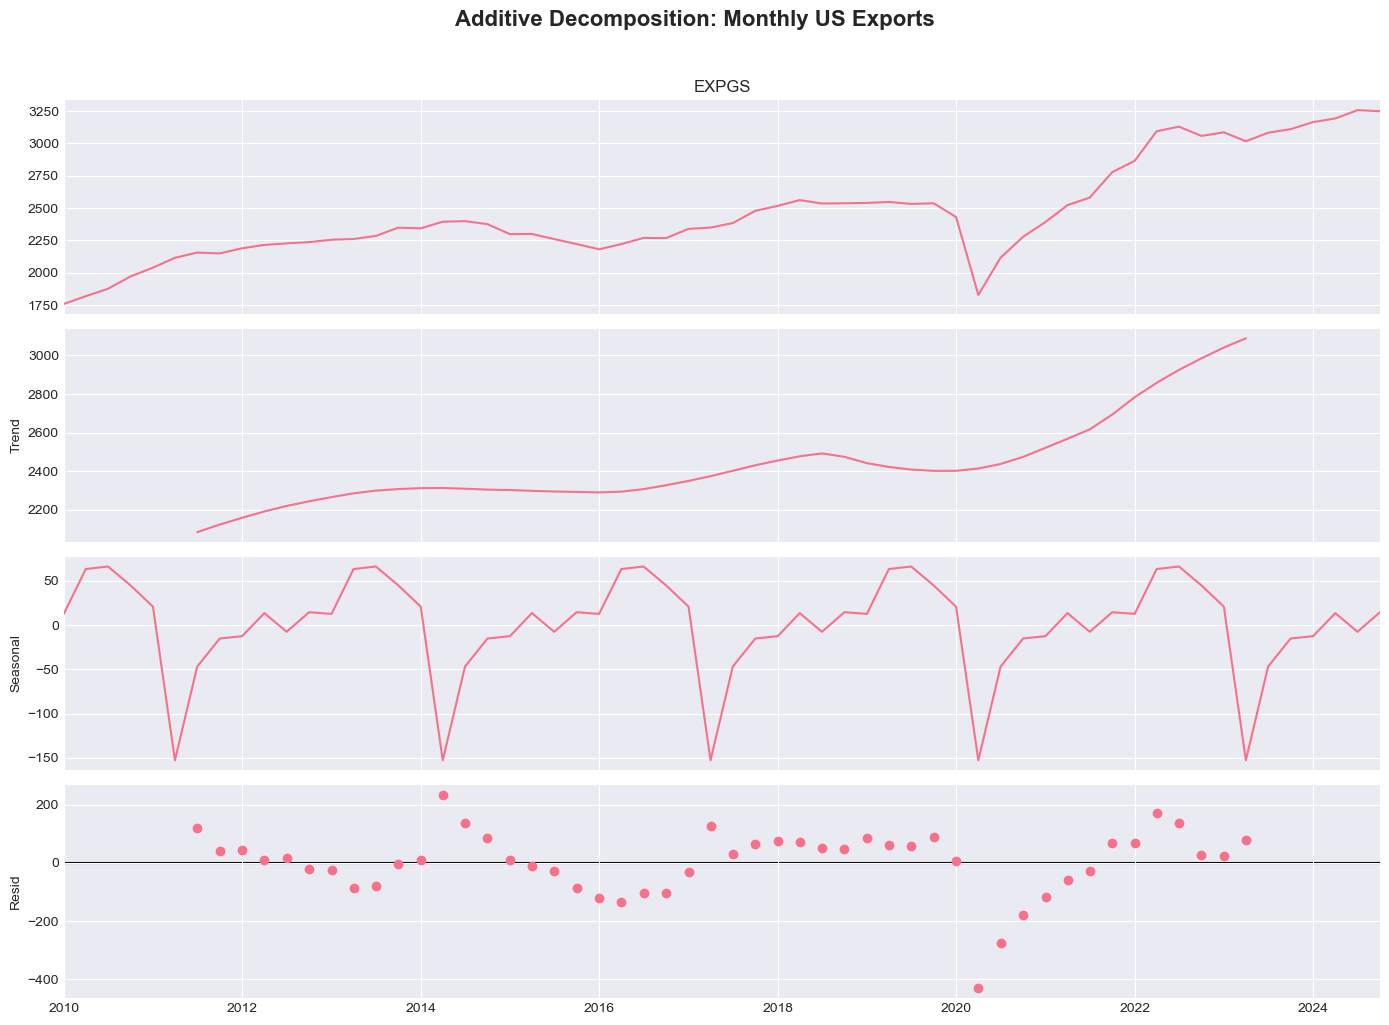


Additive decomposition assumes: Y_t = Trend + Seasonal + Remainder
Trend range: 2084.27 to 3088.78
Seasonal range: -152.81 to 66.12
Remainder std: 114.41


In [12]:
# Classical decomposition - Additive
# For monthly data, we use period=12 for yearly seasonality
print("Performing additive decomposition on monthly exports...")
decomp_additive = seasonal_decompose(exports_monthly.dropna(), model='additive', period=12)

# Plot the decomposition
fig = decomp_additive.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Additive Decomposition: Monthly US Exports', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nAdditive decomposition assumes: Y_t = Trend + Seasonal + Remainder")
print(f"Trend range: {decomp_additive.trend.min():.2f} to {decomp_additive.trend.max():.2f}")
print(f"Seasonal range: {decomp_additive.seasonal.min():.2f} to {decomp_additive.seasonal.max():.2f}")
print(f"Remainder std: {decomp_additive.resid.std():.2f}")


Performing multiplicative decomposition on monthly exports...


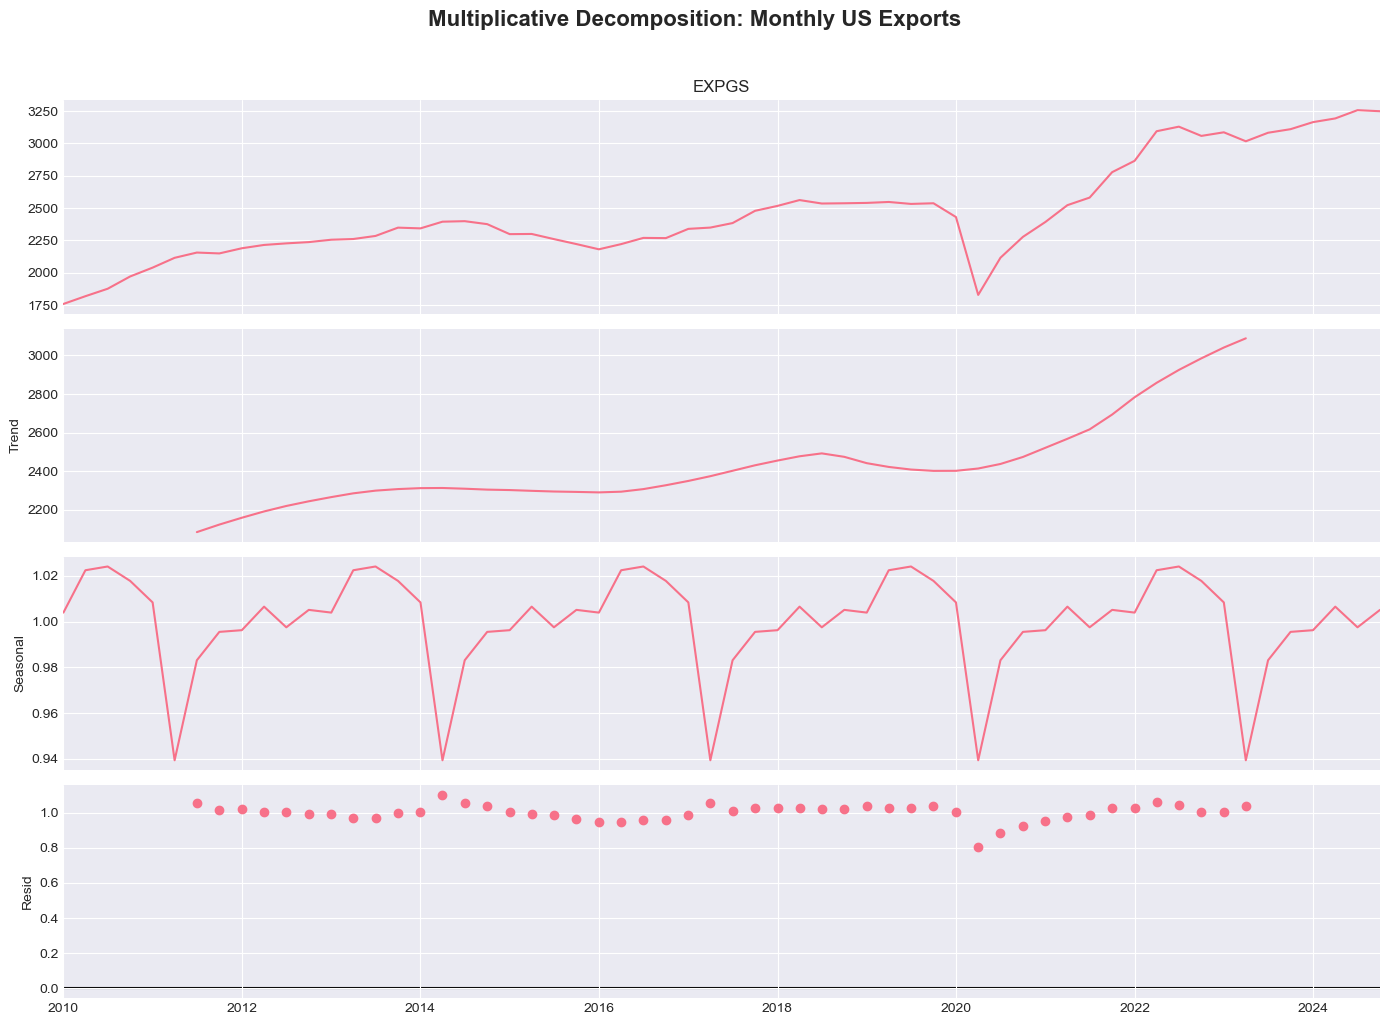


Multiplicative decomposition assumes: Y_t = Trend × Seasonal × Remainder
Trend range: 2084.27 to 3088.78
Seasonal range: 0.939 to 1.024
Remainder std: 0.0481


In [13]:
# Classical decomposition - Multiplicative
# Multiplicative is appropriate when seasonal variation grows with the level
print("Performing multiplicative decomposition on monthly exports...")
decomp_multiplicative = seasonal_decompose(exports_monthly.dropna(), model='multiplicative', period=12)

# Plot the decomposition
fig = decomp_multiplicative.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Multiplicative Decomposition: Monthly US Exports', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nMultiplicative decomposition assumes: Y_t = Trend × Seasonal × Remainder")
print(f"Trend range: {decomp_multiplicative.trend.min():.2f} to {decomp_multiplicative.trend.max():.2f}")
print(f"Seasonal range: {decomp_multiplicative.seasonal.min():.3f} to {decomp_multiplicative.seasonal.max():.3f}")
print(f"Remainder std: {decomp_multiplicative.resid.std():.4f}")


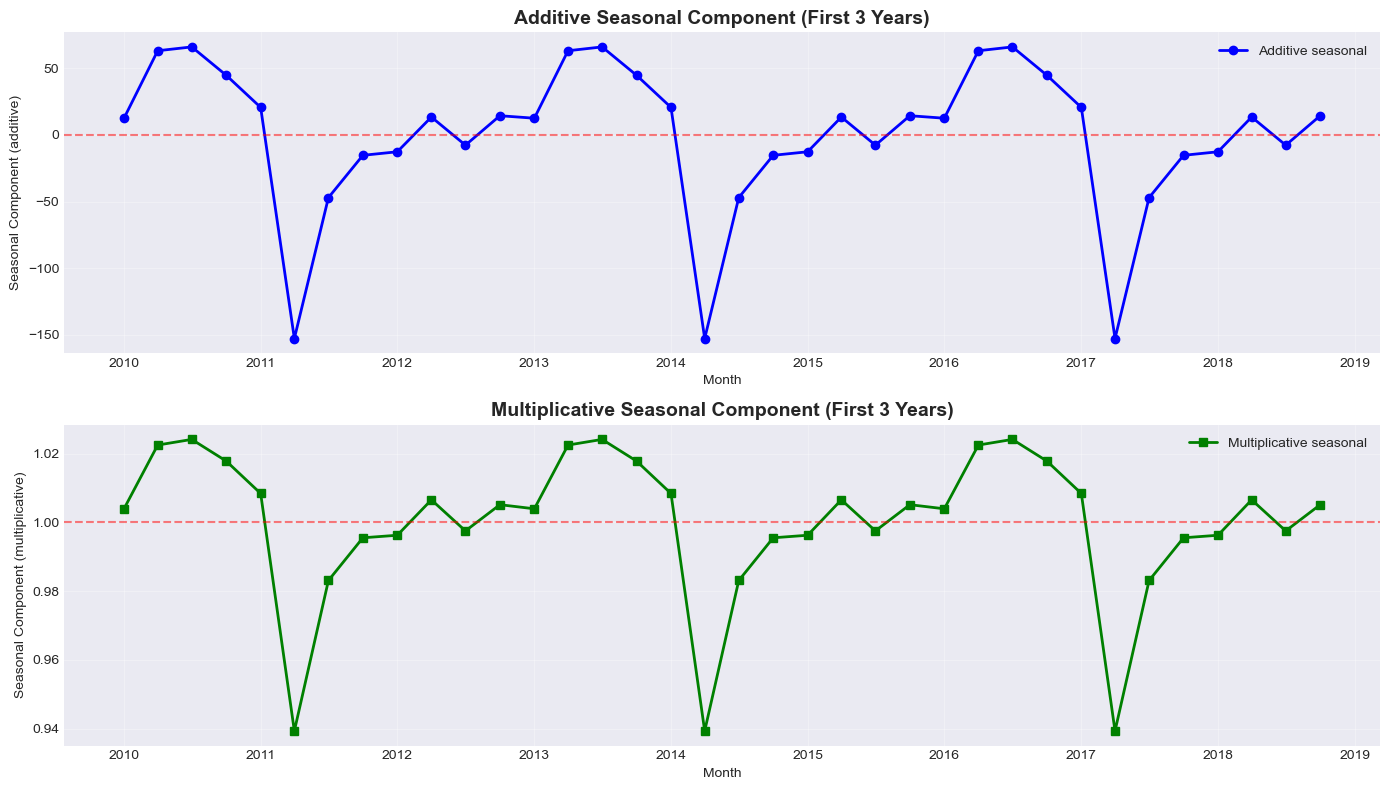

Key difference:
- Additive: Seasonal component adds/subtracts a fixed amount (centered around 0)
- Multiplicative: Seasonal component multiplies by a factor (centered around 1.0)
- Choose multiplicative when seasonal amplitude grows with the level of the series


In [14]:
# Compare additive vs multiplicative seasonal components
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot first 36 months to see seasonal pattern clearly
months_to_plot = 36

# Additive seasonal component
axes[0].plot(decomp_additive.seasonal.iloc[:months_to_plot], 
             marker='o', linewidth=2, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0].set_title('Additive Seasonal Component (First 3 Years)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Seasonal Component (additive)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(['Additive seasonal'], loc='upper right')

# Multiplicative seasonal component
axes[1].plot(decomp_multiplicative.seasonal.iloc[:months_to_plot], 
             marker='s', linewidth=2, color='green')
axes[1].axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
axes[1].set_title('Multiplicative Seasonal Component (First 3 Years)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Seasonal Component (multiplicative)')
axes[1].grid(True, alpha=0.3)
axes[1].legend(['Multiplicative seasonal'], loc='upper right')

plt.tight_layout()
plt.show()

print("Key difference:")
print("- Additive: Seasonal component adds/subtracts a fixed amount (centered around 0)")
print("- Multiplicative: Seasonal component multiplies by a factor (centered around 1.0)")
print("- Choose multiplicative when seasonal amplitude grows with the level of the series")


### STL Decomposition: A Modern Alternative

**STL (Seasonal–Trend decomposition using Loess)** is preferred over classical decomposition because:

1. **Handles changing seasonal patterns**: Seasonality can evolve over time
2. **Robust to outliers**: Less sensitive to extreme observations
3. **Flexible**: Works with any seasonal frequency
4. **Local estimation**: Uses nearby observations, not the entire dataset

**Key insight**: STL estimates trend and seasonality locally in time, allowing patterns to change gradually.


Performing STL decomposition on monthly exports...


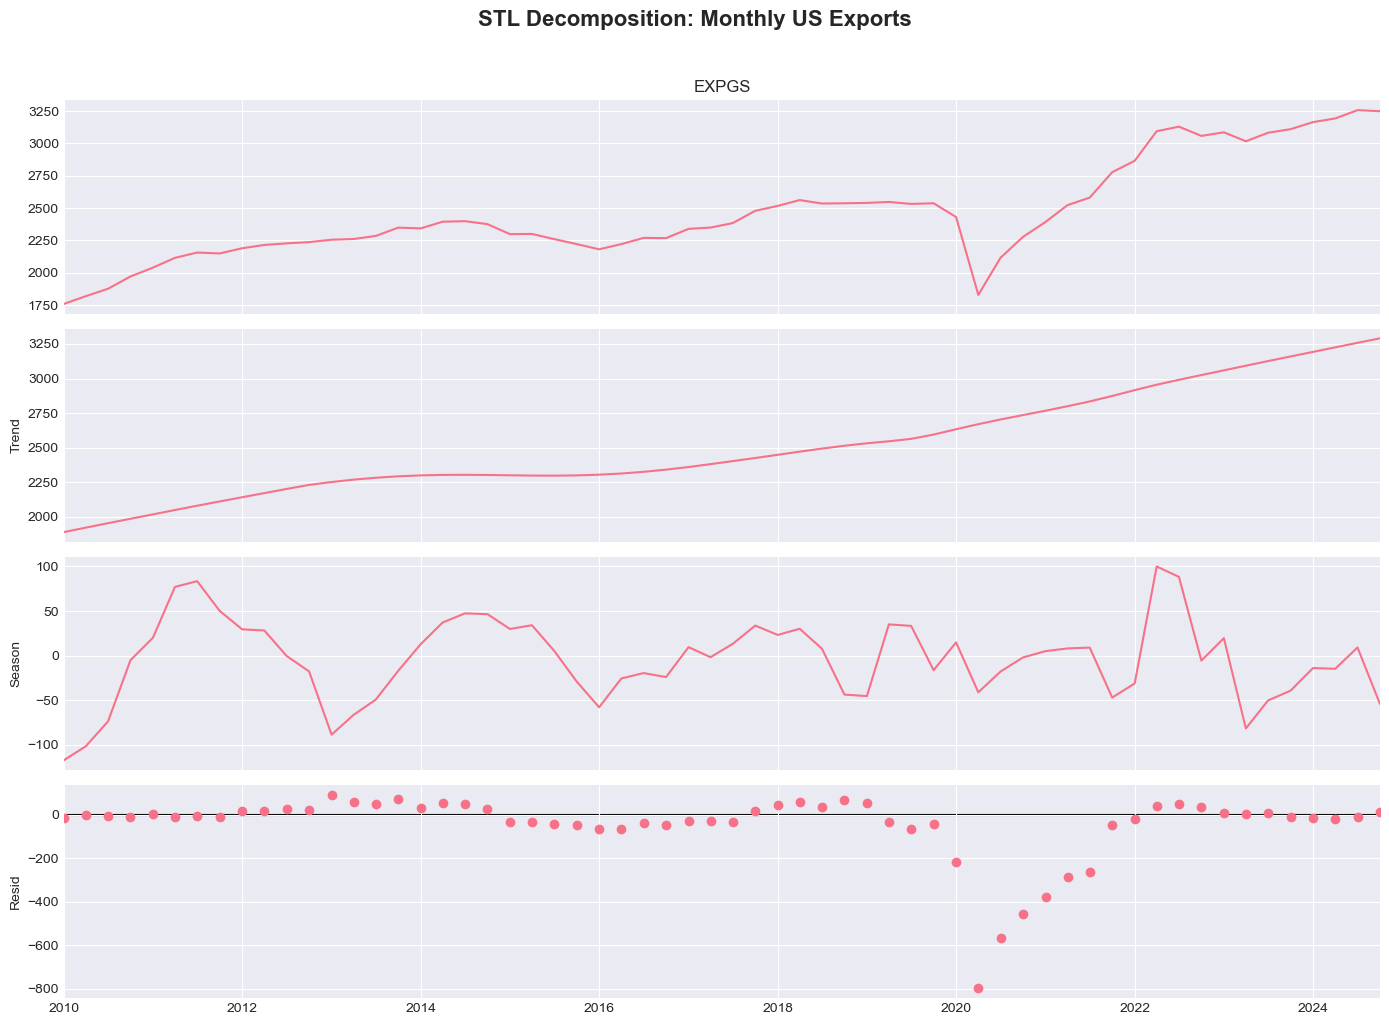


STL decomposition components:
Trend range: 1889.88 to 3290.57
Seasonal range: -117.66 to 99.99
Remainder std: 157.51


In [15]:
# STL Decomposition
# STL is more flexible and robust than classical decomposition
print("Performing STL decomposition on monthly exports...")
stl = STL(exports_monthly.dropna(), period=12, robust=True)
stl_result = stl.fit()

# Plot STL decomposition
fig = stl_result.plot()
fig.set_size_inches(14, 10)
plt.suptitle('STL Decomposition: Monthly US Exports', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nSTL decomposition components:")
print(f"Trend range: {stl_result.trend.min():.2f} to {stl_result.trend.max():.2f}")
print(f"Seasonal range: {stl_result.seasonal.min():.2f} to {stl_result.seasonal.max():.2f}")
print(f"Remainder std: {stl_result.resid.std():.2f}")


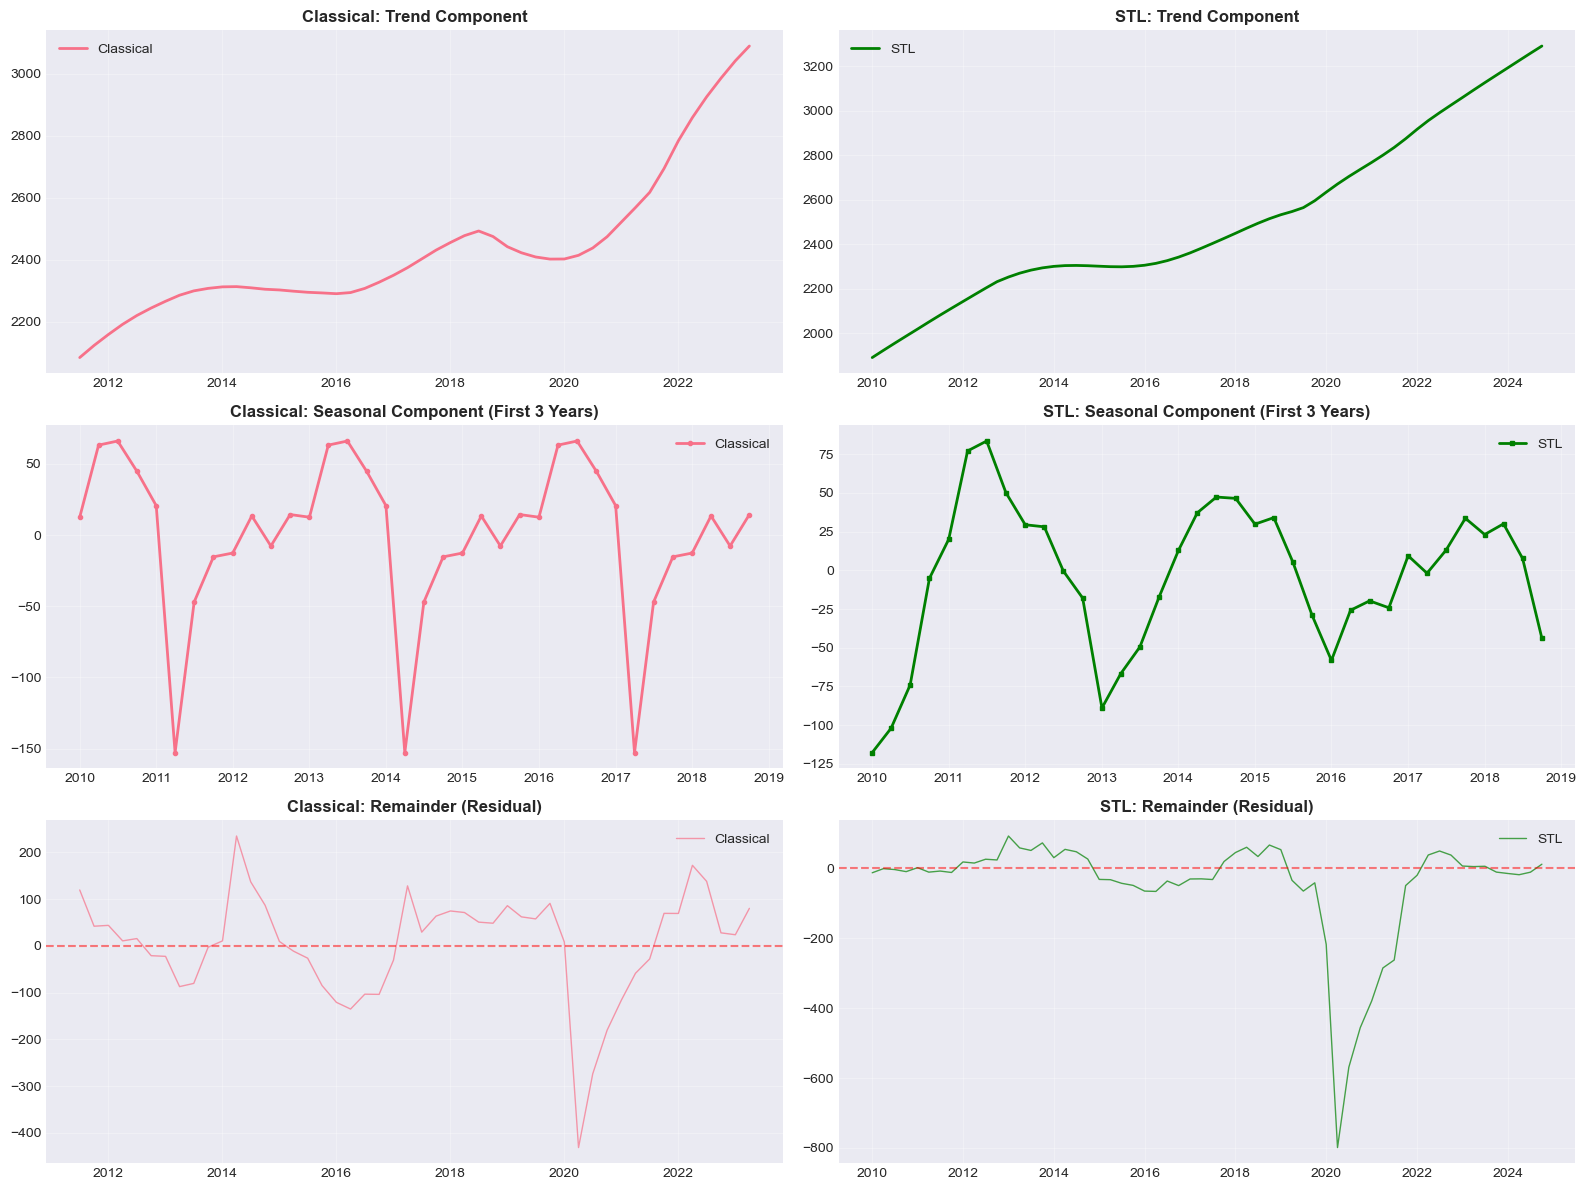

Key differences:
1. STL trend is smoother and more flexible
2. STL seasonal component can change over time (not shown in first 3 years)
3. STL remainder typically has smaller variance (better separation)


In [16]:
# Compare Classical vs STL decomposition
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Trend comparison
axes[0, 0].plot(exports_monthly.index, decomp_additive.trend, label='Classical', linewidth=2)
axes[0, 0].set_title('Classical: Trend Component', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].plot(exports_monthly.index, stl_result.trend, label='STL', linewidth=2, color='green')
axes[0, 1].set_title('STL: Trend Component', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Seasonal comparison (first 3 years)
axes[1, 0].plot(decomp_additive.seasonal.iloc[:36], label='Classical', linewidth=2, marker='o', markersize=3)
axes[1, 0].set_title('Classical: Seasonal Component (First 3 Years)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

axes[1, 1].plot(stl_result.seasonal.iloc[:36], label='STL', linewidth=2, color='green', marker='s', markersize=3)
axes[1, 1].set_title('STL: Seasonal Component (First 3 Years)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

# Remainder comparison
axes[2, 0].plot(exports_monthly.index, decomp_additive.resid, label='Classical', linewidth=1, alpha=0.7)
axes[2, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2, 0].set_title('Classical: Remainder (Residual)', fontweight='bold')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].legend()

axes[2, 1].plot(exports_monthly.index, stl_result.resid, label='STL', linewidth=1, color='green', alpha=0.7)
axes[2, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2, 1].set_title('STL: Remainder (Residual)', fontweight='bold')
axes[2, 1].grid(True, alpha=0.3)
axes[2, 1].legend()

plt.tight_layout()
plt.show()

print("Key differences:")
print("1. STL trend is smoother and more flexible")
print("2. STL seasonal component can change over time (not shown in first 3 years)")
print("3. STL remainder typically has smaller variance (better separation)")


## Part 5: Decomposition for Daily Data (Stock Prices)

Daily stock prices don't have monthly/yearly seasonality, but they do have:
- Trends (long-run movements)
- Weekly patterns (lower volume on Fridays)
- Irregular fluctuations (market shocks)

Let's apply decomposition to understand the structure.


Performing STL decomposition on daily stock prices...
Using period=252 to capture potential yearly patterns


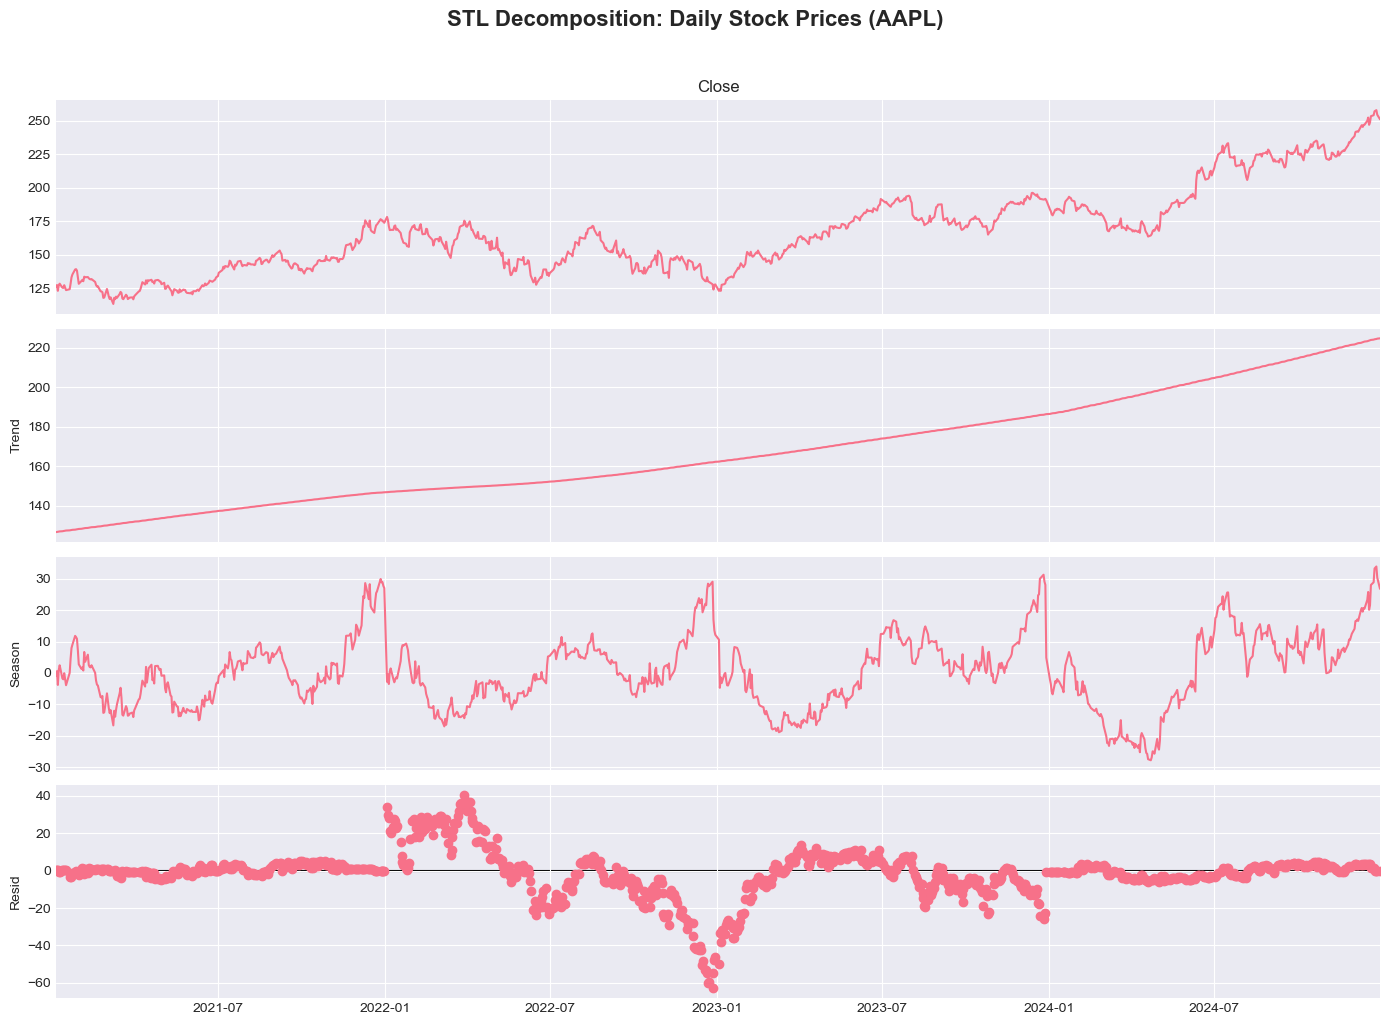


Stock price decomposition insights:
1. Trend: Captures long-term growth/decline
2. Seasonal: Yearly patterns (if any)
3. Remainder: Daily fluctuations and market shocks

Remainder standard deviation: $12.44
This represents the daily volatility after removing trend and seasonality


In [17]:
# For daily stock prices, we might look for weekly patterns (period=5 for business days)
# But stock prices are better modeled with trend + remainder (no strong seasonality)
# Let's use a longer period to capture longer-term patterns

# Use period=252 for yearly pattern in trading days (approximately 252 trading days per year)
print("Performing STL decomposition on daily stock prices...")
print("Using period=252 to capture potential yearly patterns")

# Use a subset of data for cleaner visualization
stock_subset = daily_prices['2021-01-01':'2024-12-31'].dropna()

stl_stock = STL(stock_subset, period=252, robust=True)
stl_stock_result = stl_stock.fit()

# Plot STL decomposition
fig = stl_stock_result.plot()
fig.set_size_inches(14, 10)
plt.suptitle('STL Decomposition: Daily Stock Prices (AAPL)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nStock price decomposition insights:")
print("1. Trend: Captures long-term growth/decline")
print("2. Seasonal: Yearly patterns (if any)")
print("3. Remainder: Daily fluctuations and market shocks")
print(f"\nRemainder standard deviation: ${stl_stock_result.resid.std():.2f}")
print("This represents the daily volatility after removing trend and seasonality")


## Summary: What Decomposition Tells Us

**Decomposition helps us:**

1. **Understand structure**: Separates trend, seasonality, and noise
2. **Diagnose patterns**: Identify what needs modeling
3. **Guide model selection**: 
   - Strong seasonality → seasonal models needed
   - Changing trend → flexible trend models
   - Persistent remainder → ARIMA models for dependence

**Important reminder:**

- Decomposition is a **diagnostic tool**, not a forecasting model
- It reveals structure but doesn't predict the future
- Use decomposition to inform which models to use

**Next steps:**

- **Lesson 3**: ETS models (exponential smoothing) - model trend and seasonality directly
- **Lesson 4**: ARIMA models - model dependence in the remainder


## Key Takeaways

### Time Series Structure
- The time index is essential - it enables lag operations, rolling windows, and resampling
- Frequency matters (daily, monthly, etc.) - determines possible seasonality
- Always use proper time indexing in pandas

### Visualization (Easy Plotting!)
- **Time plots**: Reveal trends, level shifts, outliers, structural breaks
- **ACF plots**: Show temporal dependence and autocorrelation patterns
- **Box plots**: Quick visual way to identify outliers
- **Always visualize before modeling** - plots reveal patterns that guide analysis

### Structural Breaks (e.g., COVID-19 Impact)
- **Structural break**: Sudden change in level or trend of a time series
- **Level change**: Sudden shift up or down (e.g., unemployment spike in March 2020)
- **Trend change**: Change in growth rate (e.g., recovery after COVID)
- **Visual identification**: Plot with vertical line marking break date using `plot_with_break()`
- **Analysis**: Compare statistics (mean, std, trend) before and after break
- **Real-world example**: COVID-19 created breaks in unemployment, retail sales, GDP

### Decomposition
- **Additive**: $Y_t = T_t + S_t + R_t$ (constant seasonal amplitude)
- **Multiplicative**: $Y_t = T_t \times S_t \times R_t$ (seasonal amplitude grows with level)
- **STL**: Preferred method - handles changing patterns, robust to outliers

### Choosing the Right Method
- Constant seasonal size → Additive
- Proportional seasonal size → Multiplicative (or log-transform)
- Need robustness/flexibility → STL


## References

- ECON 5140: Applied Econometrics, Lesson 2 - Time Series Foundations & Decomposition
- Statsmodels documentation: https://www.statsmodels.org/
- Hyndman, R. J., & Athanasopoulos, G. (2021). *Forecasting: principles and practice* (3rd ed.). Available at https://otexts.com/fpp3/
- FRED Economic Data: https://fred.stlouisfed.org/
- yfinance: https://pypi.org/project/yfinance/
